# Machine Learning: Pipeline de modelado de ocupación hospitalaria

## Preparación de datos

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


# Cargar dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('/content/1_camas_hosp_clima_encod.csv')
df.head()

Saving 1_camas_hosp_clima_encod.csv to 1_camas_hosp_clima_encod.csv


,fecha,hosp_fract_cadera,hosp_insuf_card,hosp_infarto_miorardio,hosp_ictus,hosp_epoc,camas_iniciales_planta,camas_habilitadas_planta,camas_ocupadas_planta,camas_iniciales_uci,...,hospital_Hospital Universitario Río Hortega,provincia_Burgos,provincia_León,provincia_Palencia,provincia_Salamanca,provincia_Segovia,provincia_Soria,provincia_Valladolid,provincia_Zamora,provincia_Ávila
0,2022-01-01,4.0,10.0,5.0,7.0,7.0,365.0,325.0,167.0,16.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2022-01-01,3.0,4.0,0.0,3.0,1.0,319.0,274.0,131.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2022-01-01,4.0,17.0,5.0,5.0,10.0,395.0,358.0,265.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2022-01-01,1.0,26.0,1.0,8.0,13.0,422.0,368.0,196.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2022-01-01,8.0,45.0,2.0,12.0,15.0,842.0,755.0,457.0,42.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocesar columnas

In [ ]:
import pandas as pd

# Convertir fecha
df["fecha"] = pd.to_datetime(df["fecha"])

# Crear el target total
df["camas_ocupadas_total"] = df["camas_ocupadas_planta"] + df["camas_ocupadas_uci"]

# Revisar columnas clave
print(df.columns)

Index(['fecha', 'hosp_fract_cadera', 'hosp_insuf_card',
       'hosp_infarto_miorardio', 'hosp_ictus', 'hosp_epoc',
       'camas_iniciales_planta', 'camas_habilitadas_planta',
       'camas_ocupadas_planta', 'camas_iniciales_uci', 'camas_habilitadas_uci',
       'camas_ocupadas_uci', 'camas_ocupadas_covid_uci', 'codigo_ine', 'tmax',
       'tmin', 'precip_mm', 'humedad_%', 'viento_kph',
       'hospital_Complejo Asistencial Universitario de Burgos',
       'hospital_Complejo Asistencial Universitario de León',
       'hospital_Complejo Asistencial Universitario de Palencia',
       'hospital_Complejo Asistencial Universitario de Salamanca',
       'hospital_Complejo Asistencial de Segovia',
       'hospital_Complejo Asistencial de Soria',
       'hospital_Complejo Asistencial de Zamora',
       'hospital_Complejo Asistencial de Ávila',
       'hospital_Hospital Clínico Universitario de Valladolid',
       'hospital_Hospital El Bierzo', 'hospital_Hospital Santiago Apóstol',
       'hos

### Dividir en entrenamiento y test

In [ ]:
# Ordenar por fecha y dividir temporalmente
df = df.sort_values("fecha")

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print("Train:", train_df["fecha"].min(), "→", train_df["fecha"].max())
print("Test:", test_df["fecha"].min(), "→", test_df["fecha"].max())

Train: 2022-01-01 00:00:00 → 2024-09-29 00:00:00
Test: 2024-09-29 00:00:00 → 2025-05-31 00:00:00


## Definir features y targets

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Targets principales: predicción de ocupación hospitalaria
targets = {
    "A_ocupacion_total": "camas_ocupadas_total",
    "B_ocupacion_planta": "camas_ocupadas_planta",
    "C_ocupacion_uci": "camas_ocupadas_uci"
}

# Variables base de capacidad hospitalaria
features_base = [
    "camas_iniciales_planta", "camas_habilitadas_planta",
    "camas_iniciales_uci", "camas_habilitadas_uci"
]

# Variables de morbilidad (hospitalizaciones por causa)
features_morbilidad = [
    "hosp_fract_cadera", "hosp_insuf_card",
    "hosp_infarto_miorardio", "hosp_ictus", "hosp_epoc"
]

# Variables climáticas (si están presentes)
features_clima = [col for col in ["tmax", "tmin", "precip_mm", "humedad_%", "viento_kph"] if col in df.columns]

# Variables de localización (hospital / provincia)
features_geo = [
    col for col in df.columns
    if col.startswith("hospital_") or col.startswith("provincia_")
]

# Combinar todas las features
features = features_base + features_morbilidad + features_clima + features_geo

# Mostrar resumen de configuración
print("\nTargets definidos:", list(targets.keys()))
print("Total de features:", len(features))
print(df.columns.tolist())


Targets definidos: ['A_ocupacion_total', 'B_ocupacion_planta', 'C_ocupacion_uci']
Total de features: 36
['fecha', 'hosp_fract_cadera', 'hosp_insuf_card', 'hosp_infarto_miorardio', 'hosp_ictus', 'hosp_epoc', 'camas_iniciales_planta', 'camas_habilitadas_planta', 'camas_ocupadas_planta', 'camas_iniciales_uci', 'camas_habilitadas_uci', 'camas_ocupadas_uci', 'camas_ocupadas_covid_uci', 'codigo_ine', 'tmax', 'tmin', 'precip_mm', 'humedad_%', 'viento_kph', 'hospital_Complejo Asistencial Universitario de Burgos', 'hospital_Complejo Asistencial Universitario de León', 'hospital_Complejo Asistencial Universitario de Palencia', 'hospital_Complejo Asistencial Universitario de Salamanca', 'hospital_Complejo Asistencial de Segovia', 'hospital_Complejo Asistencial de Soria', 'hospital_Complejo Asistencial de Zamora', 'hospital_Complejo Asistencial de Ávila', 'hospital_Hospital Clínico Universitario de Valladolid', 'hospital_Hospital El Bierzo', 'hospital_Hospital Santiago Apóstol', 'hospital_Hospita

### Entrenar y comparar modelos

In [ ]:
# Datos
X_train = train_df[features]
X_test = test_df[features]

# Modelos a comparar
modelos = {
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=300),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=300),
    "LinearRegression": LinearRegression(),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Diccionario de resultados
resultados = []

for target_name, target_col in targets.items():
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    for nombre_modelo, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        preds = modelo.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        resultados.append({
            "Target": target_name,
            "Modelo": nombre_modelo,
            "MAE": mae,
            "R2": r2
        })

# Tabla de comparación
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(["Target", "MAE"], ascending=[True, True])

,Target,Modelo,MAE,R2
3,A_ocupacion_total,MLPRegressor,26.662316,0.963584
2,A_ocupacion_total,LinearRegression,26.699416,0.964179
0,A_ocupacion_total,RandomForest,26.838611,0.964405
1,A_ocupacion_total,XGBoost,29.254045,0.954711
6,B_ocupacion_planta,LinearRegression,25.946857,0.961363
4,B_ocupacion_planta,RandomForest,25.994627,0.961183
7,B_ocupacion_planta,MLPRegressor,26.010193,0.959761
5,B_ocupacion_planta,XGBoost,27.926112,0.954470
8,C_ocupacion_uci,RandomForest,2.509449,0.931064
10,C_ocupacion_uci,LinearRegression,2.597818,0.944065


### Gráfico por Target: Comparación de MAE entre modelos

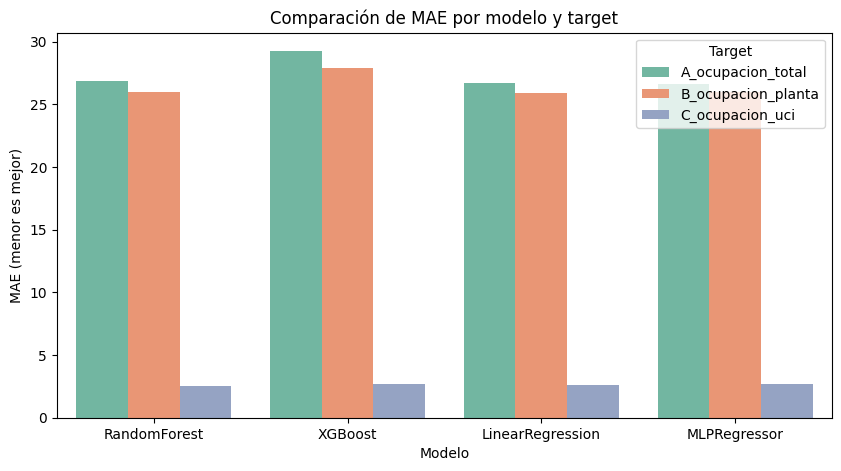

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_resultados,
    x="Modelo",
    y="MAE",
    hue="Target",
    palette="Set2"
)

plt.title("Comparación de MAE por modelo y target")
plt.ylabel("MAE (menor es mejor)")
plt.xlabel("Modelo")
plt.legend(title="Target")
plt.show()

### Comparación de R² por modelo y target

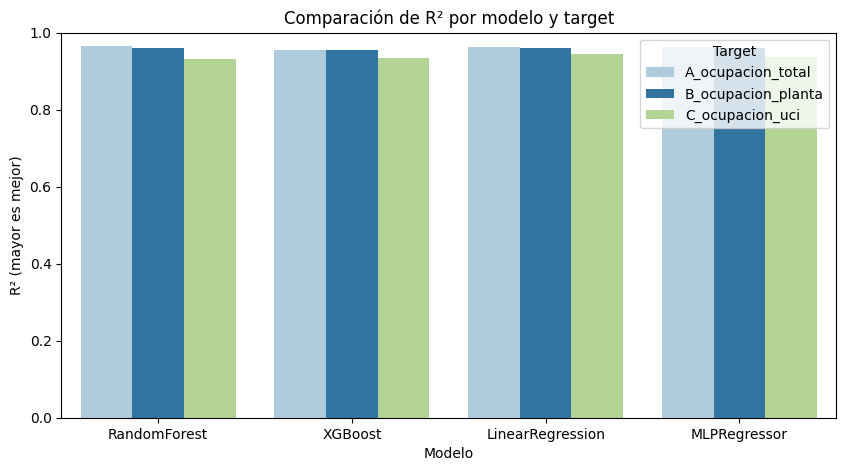

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_resultados,
    x="Modelo",
    y="R2",
    hue="Target",
    palette="Paired"
)

plt.title("Comparación de R² por modelo y target")
plt.ylabel("R² (mayor es mejor)")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.legend(title="Target")
plt.show()

### Heatmap: Resumen visual general

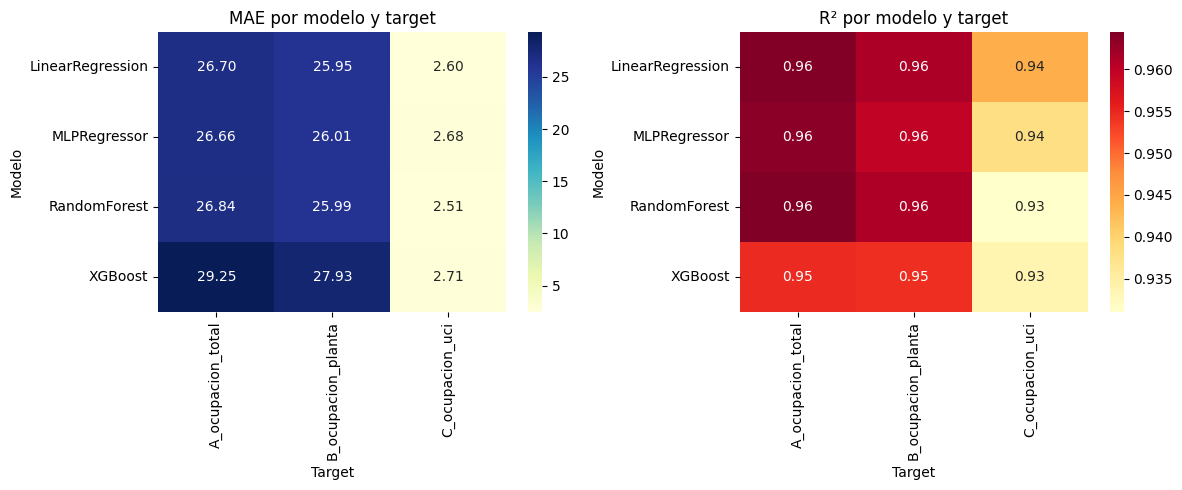

In [ ]:
pivot_mae = df_resultados.pivot(index="Modelo", columns="Target", values="MAE")
pivot_r2 = df_resultados.pivot(index="Modelo", columns="Target", values="R2")

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(pivot_mae, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[0])
axes[0].set_title("MAE por modelo y target")

sns.heatmap(pivot_r2, annot=True, cmap="YlOrRd", fmt=".2f", ax=axes[1])
axes[1].set_title("R² por modelo y target")

plt.tight_layout()
plt.show()

### Curvas Predicción vs Real

In [ ]:
import plotly.express as px

fig = px.bar(df_resultados, x="Modelo", y="R2", color="Target", barmode="group",
             title="Comparación de R² por Target (interactivo)")
fig.show()

### Histogramas de error por target y modelo

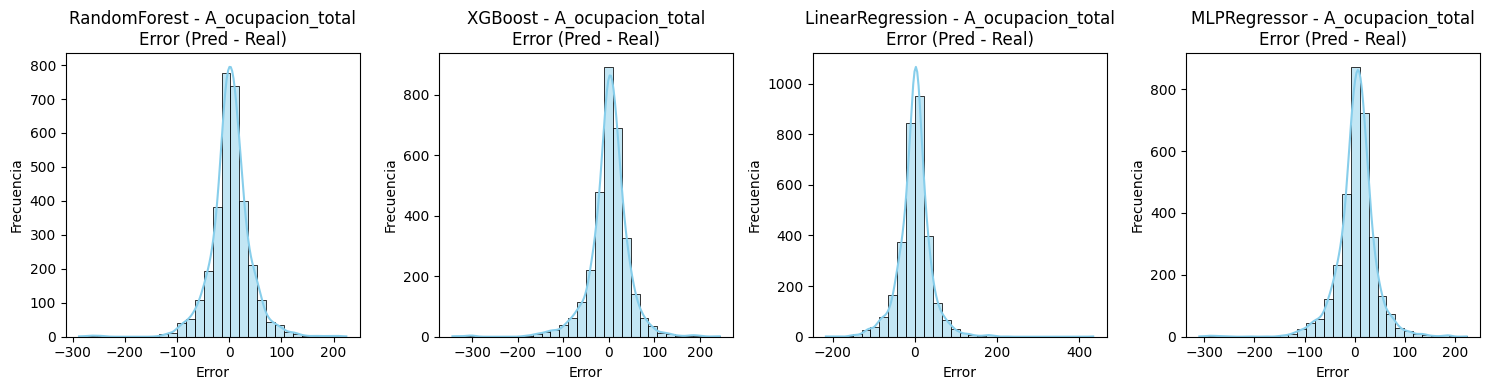

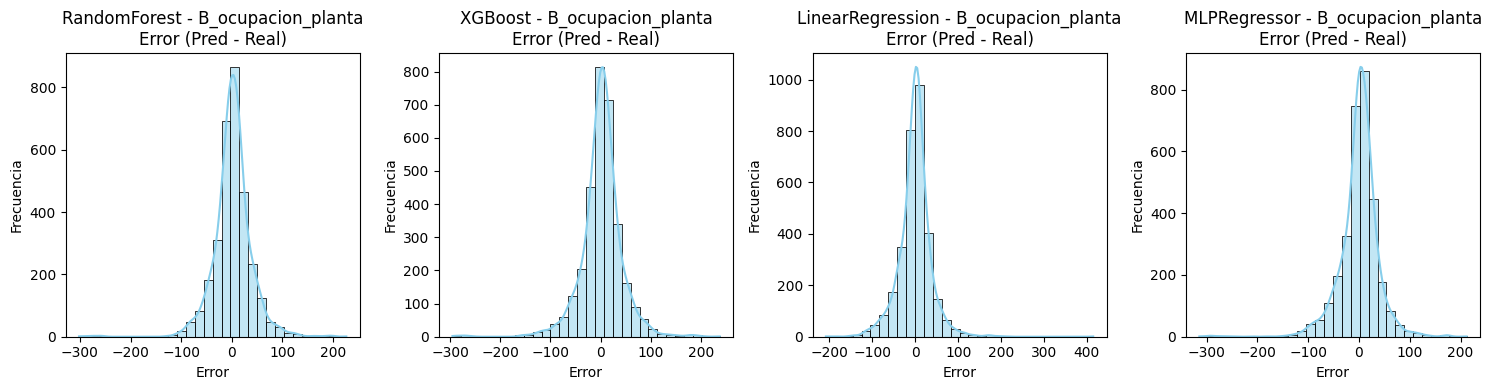

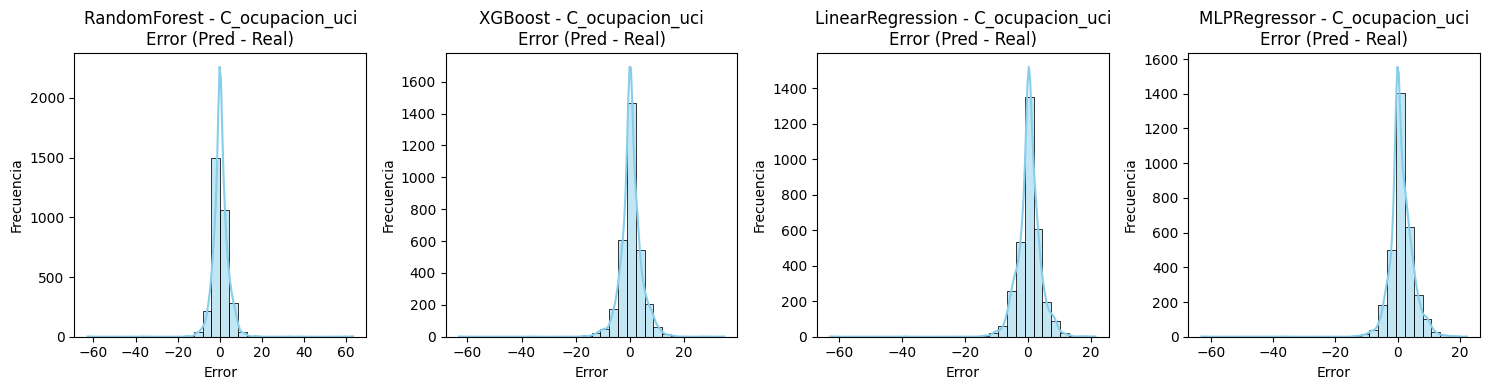

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear histogramas de error para cada modelo y target
for target_name, target_col in targets.items():
    y_test = test_df[target_col]

    plt.figure(figsize=(15, 4))
    for i, (nombre_modelo, modelo) in enumerate(modelos.items()):
        modelo.fit(X_train, train_df[target_col])
        preds = modelo.predict(X_test)
        errores = preds - y_test

        plt.subplot(1, len(modelos), i+1)
        sns.histplot(errores, kde=True, bins=30, color="skyblue")
        plt.title(f"{nombre_modelo} - {target_name}\nError (Pred - Real)")
        plt.xlabel("Error")
        plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

### Correlación de variables base y morbilidad con targets

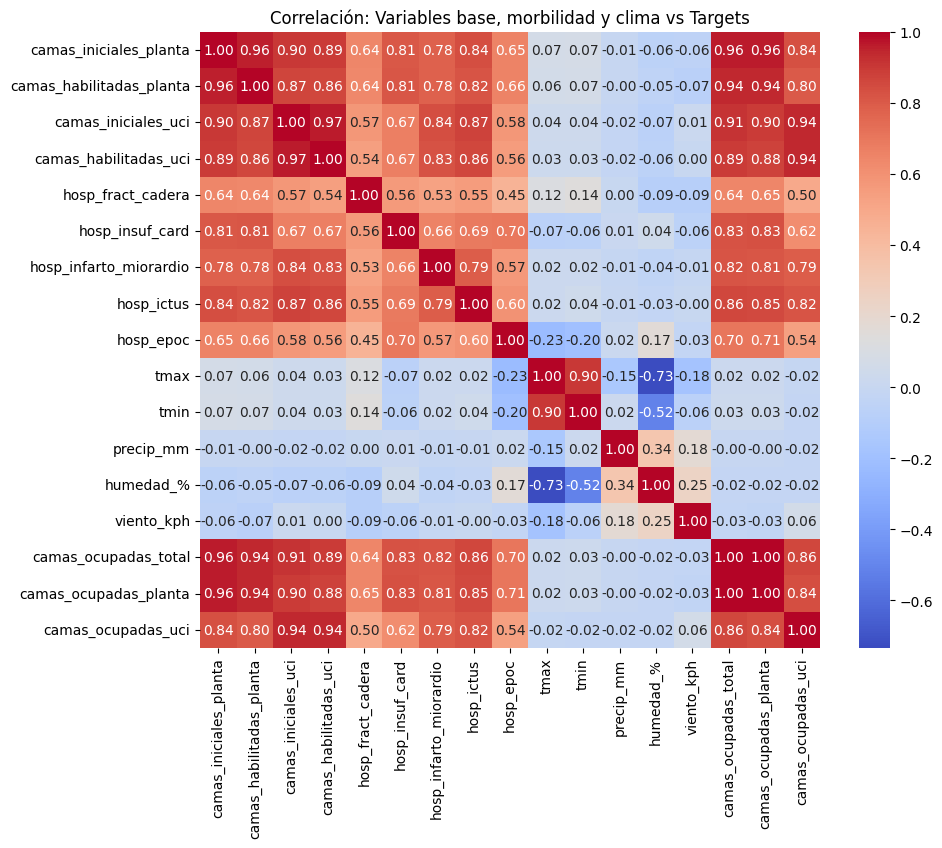

In [ ]:
features_base_morb = features_base + features_morbilidad + features_clima

df_corr_base = df[features_base_morb + list(targets.values())].corr()

plt.figure(figsize=(10,8))
sns.heatmap(df_corr_base, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlación: Variables base, morbilidad y clima vs Targets")
plt.show()

### Correlación de variables de hospital / provincia (one-hot) con targets

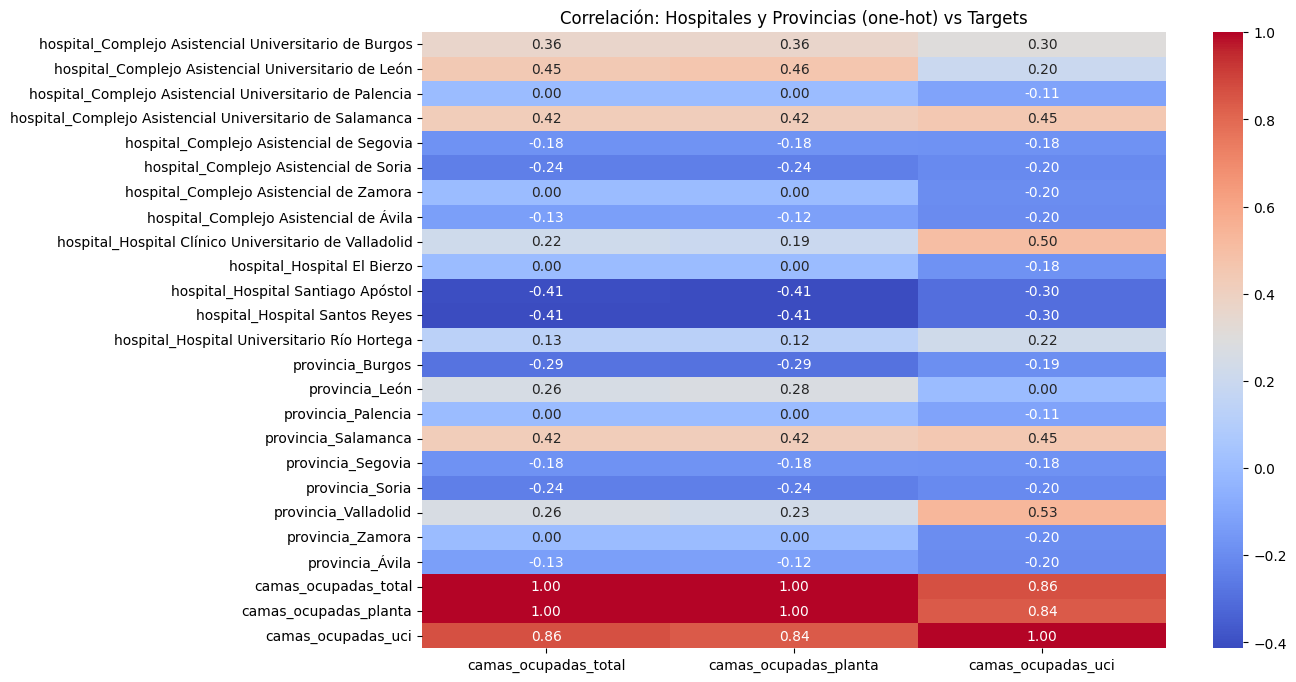

In [ ]:
features_geo = [col for col in features if col.startswith("hospital_") or col.startswith("provincia_")]

df_corr_geo = df[features_geo + list(targets.values())].corr()

# Foco solo en correlaciones >0.1 o <-0.1
threshold = 0.1
df_corr_geo_filtered = df_corr_geo.loc[:, list(targets.values())]
df_corr_geo_filtered = df_corr_geo_filtered[df_corr_geo_filtered.abs() > threshold].fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(df_corr_geo_filtered, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlación: Hospitales y Provincias (one-hot) vs Targets")
plt.show()

### Correlación individual por target

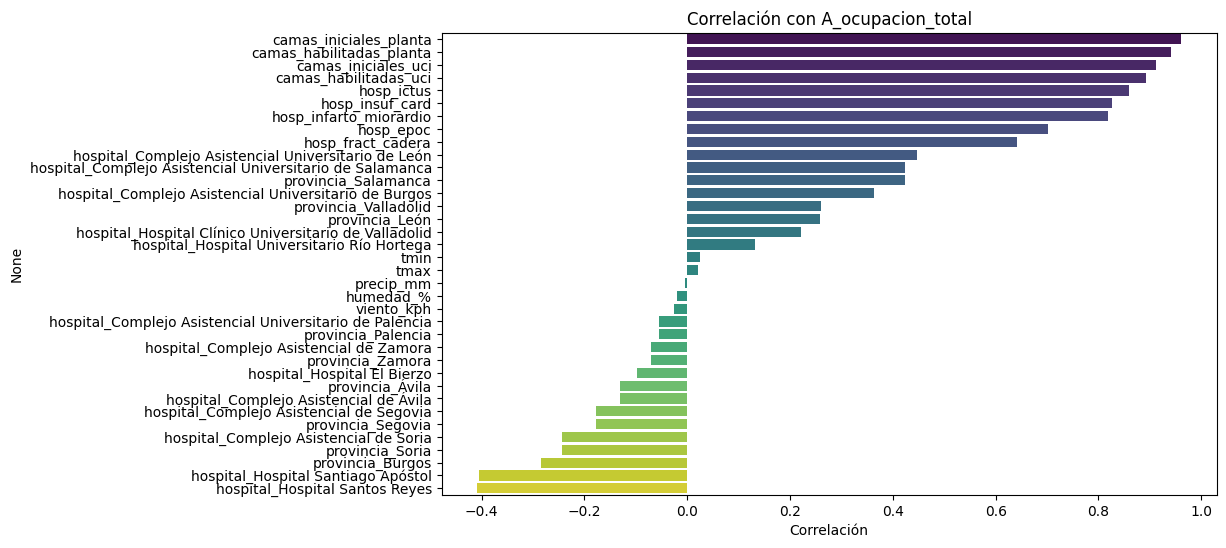

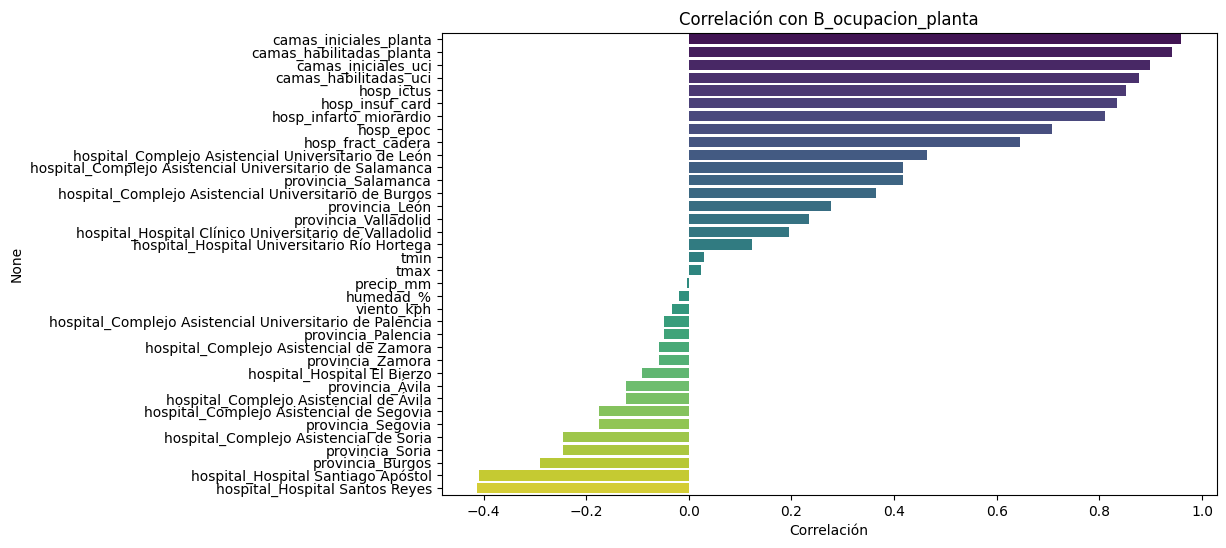

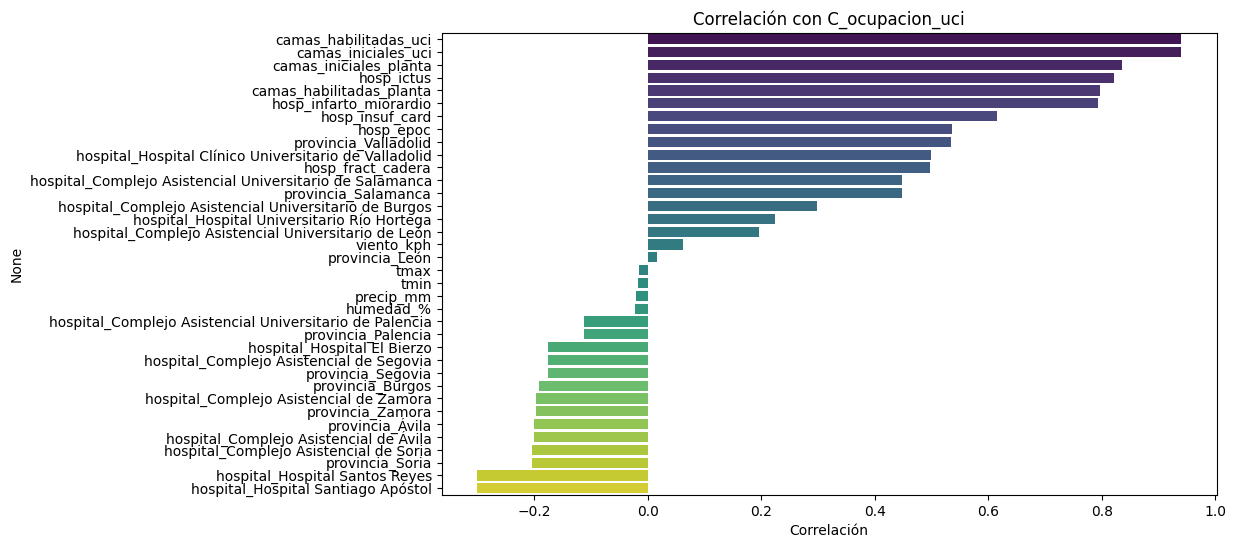

In [ ]:
for target_name, target_col in targets.items():
    corr_target = df[features_base_morb + features_geo].corrwith(df[target_col])
    corr_target = corr_target.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")
    plt.title(f"Correlación con {target_name}")
    plt.xlabel("Correlación")
    plt.show()

## Preparación para clasificación (alta ocupación / demanda crítica)

### Creación de una variable binaria: Alta ocupación y Demanda crítica

In [ ]:
df["ocupacion_ratio"] = df["camas_ocupadas_total"] / (
    df["camas_habilitadas_planta"] + df["camas_habilitadas_uci"]
)

df["alta_ocupacion"] = (df["ocupacion_ratio"] > 0.8).astype(int)

# Ordenar por fecha y dividir temporalmente
df = df.sort_values("fecha")

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print("Train:", train_df["fecha"].min(), "→", train_df["fecha"].max())
print("Test:", test_df["fecha"].min(), "→", test_df["fecha"].max())

Train: 2022-01-01 00:00:00 → 2024-09-29 00:00:00
Test: 2024-09-29 00:00:00 → 2025-05-31 00:00:00


### Entrenar modelos para clasificación

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc

modelos_clf = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=300),
    "XGBoost": XGBClassifier(random_state=42, n_estimators=300),
    "LogisticRegression": LogisticRegression(max_iter=500),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df["alta_ocupacion"]
y_test = test_df["alta_ocupacion"]

### Curvas ROC comparativas

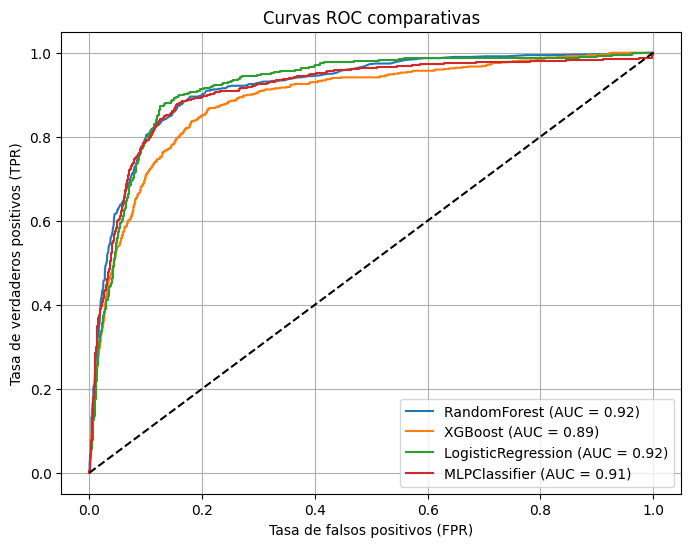

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train, y_train)
    y_score = modelo.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.grid(True)
plt.show()

### Curvas Precision–Recall comparativas

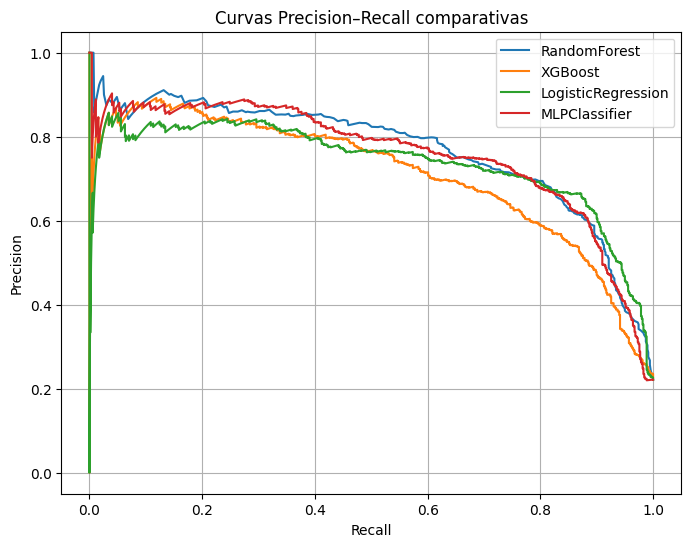

In [ ]:
plt.figure(figsize=(8,6))

for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train, y_train)
    y_score = modelo.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=nombre)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision–Recall comparativas")
plt.legend()
plt.grid(True)
plt.show()

## Mejor Modelo

### Target, R2 y “ranking”

In [ ]:
# Agregar ranking (1 = mejor)
df_resultados["rank_MAE"] = df_resultados.groupby("Target")["MAE"].rank(ascending=True)
df_resultados["rank_R2"] = df_resultados.groupby("Target")["R2"].rank(ascending=False)

# Puntaje combinado (menor = mejor)
df_resultados["score_global"] = df_resultados["rank_MAE"] + df_resultados["rank_R2"]

# Mostrar resumen
tabla_mejores = (
    df_resultados.sort_values(["Target", "score_global"])
    .groupby("Target")
    .first()
    .reset_index()
)

tabla_mejores

,Target,Modelo,MAE,R2,rank_MAE,rank_R2,score_global
0,A_ocupacion_total,RandomForest,26.838611,0.964405,3.0,1.0,4.0
1,B_ocupacion_planta,LinearRegression,25.946857,0.961363,1.0,1.0,2.0
2,C_ocupacion_uci,LinearRegression,2.597818,0.944065,2.0,1.0,3.0


### AUC-ROC, Average Precision (AP) y Accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

resultados_clf = []

for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_score = modelo.predict_proba(X_test)[:, 1]

    auc_roc = roc_auc_score(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    acc = accuracy_score(y_test, y_pred)

    resultados_clf.append({
        "Modelo": nombre,
        "AUC_ROC": auc_roc,
        "Average_Precision": ap,
        "Accuracy": acc
    })

df_resultados_clf = pd.DataFrame(resultados_clf)
df_resultados_clf = df_resultados_clf.sort_values("AUC_ROC", ascending=False)
df_resultados_clf

,Modelo,AUC_ROC,Average_Precision,Accuracy
2,LogisticRegression,0.919972,0.736151,0.868379
0,RandomForest,0.918425,0.766693,0.876625
3,MLPClassifier,0.910388,0.757779,0.869648
1,XGBoost,0.888920,0.709756,0.855376


### Radar Chart: Comparativa de desempeño entre modelos

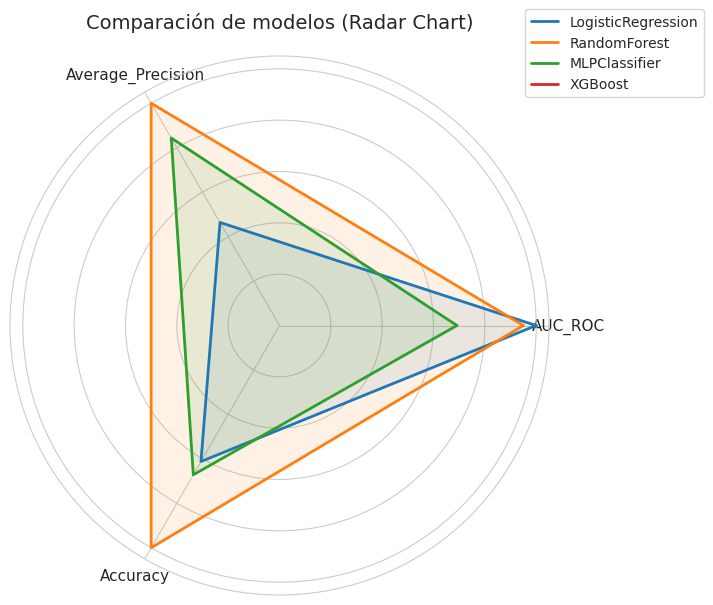

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_radar = df_resultados_clf[["Modelo", "AUC_ROC", "Average_Precision", "Accuracy"]].copy()
df_radar.set_index("Modelo", inplace=True)

df_radar = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())


labels = df_radar.columns
n_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Graficar cada modelo
for modelo, fila in df_radar.iterrows():
    valores = fila.tolist()
    valores += valores[:1]
    ax.plot(angles, valores, label=modelo, linewidth=2)
    ax.fill(angles, valores, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_yticklabels([])
ax.set_title("Comparación de modelos (Radar Chart)", fontsize=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

### Tabla final comparativa con ranking

In [ ]:
df_resultados_clf["Rank_AUC"] = df_resultados_clf["AUC_ROC"].rank(ascending=False)
df_resultados_clf["Rank_AP"] = df_resultados_clf["Average_Precision"].rank(ascending=False)
df_resultados_clf["Rank_ACC"] = df_resultados_clf["Accuracy"].rank(ascending=False)

df_resultados_clf["Score_Global"] = (
    df_resultados_clf["Rank_AUC"] + df_resultados_clf["Rank_AP"] + df_resultados_clf["Rank_ACC"]
)

tabla_final = df_resultados_clf.sort_values("Score_Global")
tabla_final

,Modelo,AUC_ROC,Average_Precision,Accuracy,Rank_AUC,Rank_AP,Rank_ACC,Score_Global
0,RandomForest,0.918425,0.766693,0.876625,2.0,1.0,1.0,4.0
2,LogisticRegression,0.919972,0.736151,0.868379,1.0,3.0,3.0,7.0
3,MLPClassifier,0.910388,0.757779,0.869648,3.0,2.0,2.0,7.0
1,XGBoost,0.888920,0.709756,0.855376,4.0,4.0,4.0,12.0


### Comparación de métricas por modelo

In [ ]:
import plotly.express as px

fig = px.bar(
    df_resultados_clf.melt(id_vars="Modelo", value_vars=["AUC_ROC", "Average_Precision", "Accuracy"]),
    x="Modelo", y="value", color="variable", barmode="group",
    title="Comparación de métricas por modelo (clasificación)"
)
fig.show()

In [ ]:
mejor_modelo = tabla_final.iloc[0]["Modelo"]
print(f"🏆 Mejor modelo global: {mejor_modelo}")

🏆 Mejor modelo global: RandomForest


## Conclusiones de los Modelos

Se implementaron los modelos Random Forest, XGBoost, Logistic Regression, MLPClassifier y Linear Regression

Nota:

* R² (Coeficiente de Determinación):	Mide la proporción de la varianza en la variable dependiente que es explicada por el modelo. Un valor más cercano a 1.0 es mejor.
* MAE (Error Absoluto Medio):	Mide la magnitud promedio de los errores entre los valores predichos y los reales. Un valor más bajo es mejor.
* AUC-ROC:	Mide la capacidad del modelo para distinguir entre clases. Un valor más cercano a 1.0 es mejor.

### Análisis curvas ROC (Receiver Operating Characteristic) y Precision-Recall.

1. Rendimiento AUC-ROC:

* Los modelos Random Forest y LogisticRegression obtuvieron el mejor rendimiento con un AUC de 0.92.

* MLPClassifier les sigue de cerca con 0.91, y XGBoost obtiene 0.89.

2. Análisis de la Curva Precision-Recall:

* Las curvas indican que Random Forest y LogisticRegression mantienen la precisión más alta en un amplio rango de Recall.

**Conclusión de AUC-ROC y Curva Precision-Recall:** Tanto Random Forest como LogisticRegression son los modelos más robustos para la tarea de clasificación. El excelente rendimiento de un modelo lineal simple como LogisticRegression (AUC=0.92) sugiere que la frontera de decisión entre las clases es linealmente separable o que gran parte de la señal se captura con una relación lineal.

### Análisis Rendimiento R² y Rendimiento MAE

1. Rendimiento R² (Ajuste del Modelo):

* Los modelos de regresión (Linear Regression, MLPRegressor, Random Forest, XGBoost) se evaluaron para predecir tres variables objetivo: A_ocupacion_total, B_ocupacion_planta y C_ocupacion_uci.

* Para los objetivos A_ocupacion_total y B_ocupacion_planta, todos los modelos muestran un ajuste excelente (R² entre 0.95 y 0.96).


| Objetivo | Linear Regression | MLPRegressor | Random Forest | XGBoost |
| :--- | :--- | :--- | :--- | :--- |
| A_ocupacion_total | 0.96 | 0.96 | 0.96 | 0.95 |
| B_ocupacion_planta | 0.96 | 0.96 | 0.96 | 0.95 |
| C_ocupacion_uci | 0.94 | 0.94 | 0.93 | 0.93 |

**Conclusión de R²:** Linear Regression y MLPRegressor son marginalmente los mejores para todos los objetivos. El alto R² de Linear Regression refuerza la idea de una fuerte relación lineal en los datos de ocupación general.

2. Rendimiento MAE (Magnitud del Error Promedio):

* Un MAE más bajo es mejor. Este valor está en las unidades de la variable objetivo (número de camas).

| Objetivo | Linear Regression | MLPRegressor | Random Forest | XGBoost |
| :--- | :--- | :--- | :--- | :--- |
| A_ocupacion_total | 26.70 | **26.66** | 26.84 | 29.25 |
| B_ocupacion_planta | **25.95** | 26.01 | 25.99 | 27.93 |
| C_ocupacion_uci | 2.60 | 2.68 | **2.51** | 2.71 |

**Conclusión de MAE:** Para la ocupación general (A_ocupacion_total y B_ocupacion_planta), Linear Regression y MLPRegressor tienen el menor error promedio, con una diferencia insignificante entre ellos.

Para el objetivo crítico C_ocupacion_uci (ocupación de UCI, que tiene un rango de valores mucho menor), Random Forest obtiene el MAE más bajo (2.51).

### Conclusión General para la Elección del Mejor Modelo

La elección final depende de la prioridad:

* Si la prioridad es la Simplicidad y Eficiencia (Regresión de Ocupación General):

El modelo Linear Regression es la mejor opción. Ofrece el mayor R² (0.96) y un MAE mínimo para las tareas de ocupación total y de planta. Su alta eficacia con un modelo lineal simple es una ventaja significativa en términos de interpretabilidad y velocidad de entrenamiento/predicción.

* Si la prioridad es la Robustez General en Todas las Tareas (Clasificación y Regresión Crítica):

El modelo Random Forest es la mejor opción en general.

Es uno de los mejores en Clasificación (AUC=0.92).

Es el mejor modelo de Regresión para la predicción de la ocupación de UCI (C_ocupacion_uci) con el menor MAE (2.51), lo cual es fundamental para una variable crítica.

**Recomendación Final:**

Para la regresión de ocupación general, Linear Regression es suficiente. Sin embargo, si se debe seleccionar un único modelo que tenga el mejor desempeño general y maneje la complejidad de manera efectiva, el modelo Random Forest es el más recomendado ya que es el mejor o está entre los mejores en todas las métricas clave (Clasificación y Regresión de UCI).

## Predicción del modelo elegido

### Comparación Real vs Predicción (línea + scatter)

MAE: 26.73
R²: 0.96


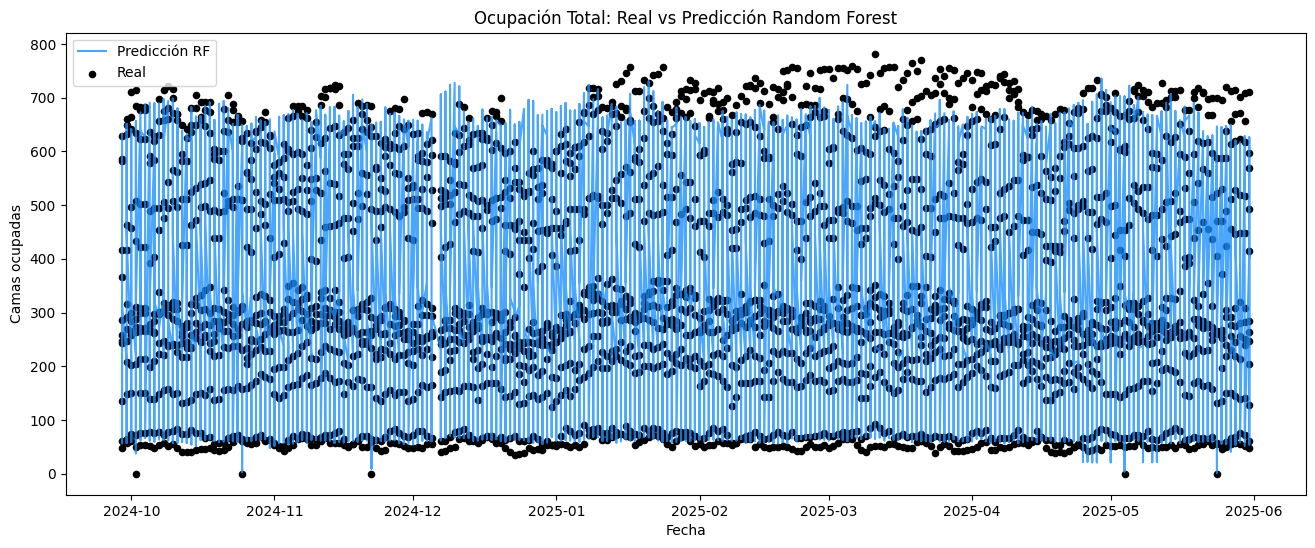

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Target que queremos predecir
target = "camas_ocupadas_total"

# Preparar datos
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

# Entrenar Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=300)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas finales
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Comparación Real vs Predicción (línea + scatter)

plt.figure(figsize=(16,6))
plt.plot(test_df["fecha"], y_pred, label="Predicción RF", color="dodgerblue", alpha=0.8)
plt.scatter(test_df["fecha"], y_test, label="Real", color="black", s=20)
plt.title("Ocupación Total: Real vs Predicción Random Forest")
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas")
plt.legend()
plt.show()

### Train + Test + Predicción Random Forest

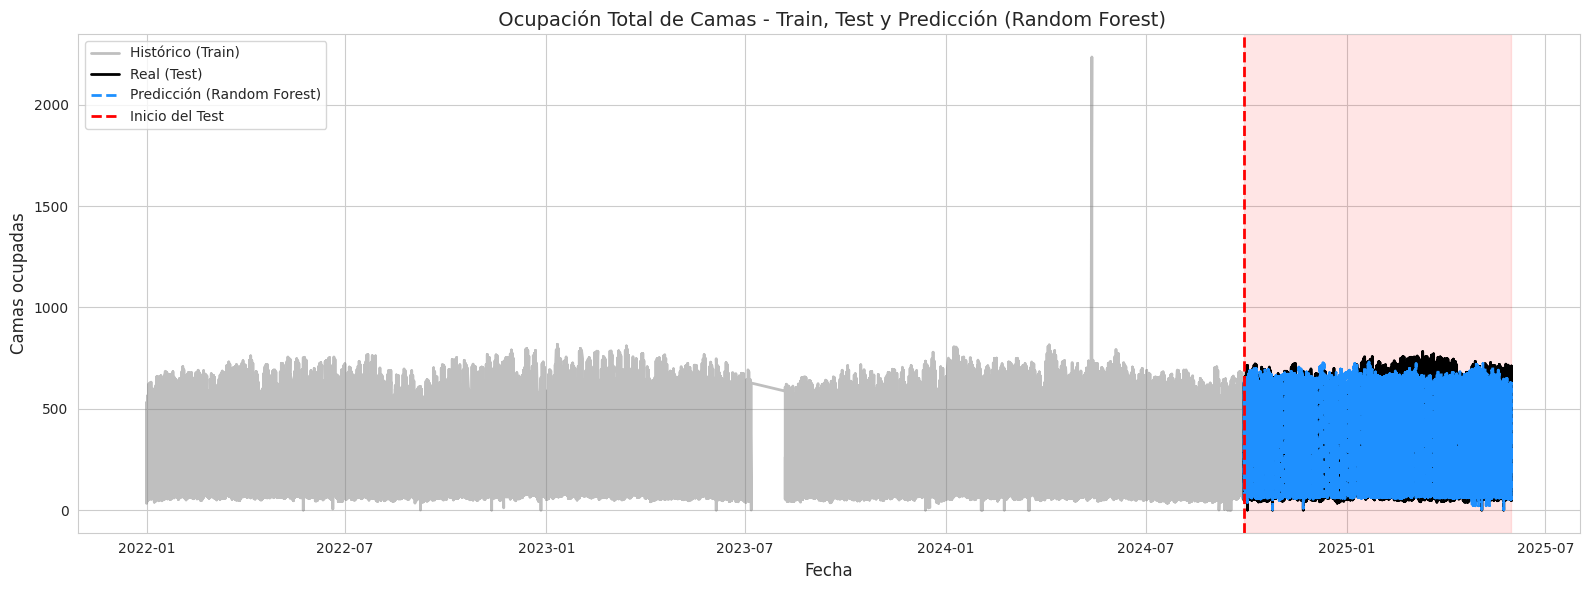

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predicciones del test
test_df["pred_camas_total"] = y_pred

# Fecha de corte entre train y test
fecha_corte = test_df["fecha"].min()

plt.figure(figsize=(16,6))
sns.set_style("whitegrid")

# Histórico (Train)
plt.plot(train_df["fecha"], train_df["camas_ocupadas_total"],
         label="Histórico (Train)", color="gray", alpha=0.5, linewidth=2)

# 2Valores reales del Test
plt.plot(test_df["fecha"], test_df["camas_ocupadas_total"],
         label="Real (Test)", color="black", linewidth=2)

# Predicciones
plt.plot(test_df["fecha"], test_df["pred_camas_total"],
         label="Predicción (Random Forest)", color="dodgerblue", linewidth=2, linestyle="--")

# Línea de corte entre train y test
plt.axvline(x=fecha_corte, color="red", linestyle="--", linewidth=2, label="Inicio del Test")

# Fondo sombreado para resaltar el período de predicción
plt.axvspan(fecha_corte, test_df["fecha"].max(), color="red", alpha=0.1)

# Títulos y ejes
plt.title(" Ocupación Total de Camas - Train, Test y Predicción (Random Forest)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Camas ocupadas", fontsize=12)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

### Residuals plot (error vs fecha)

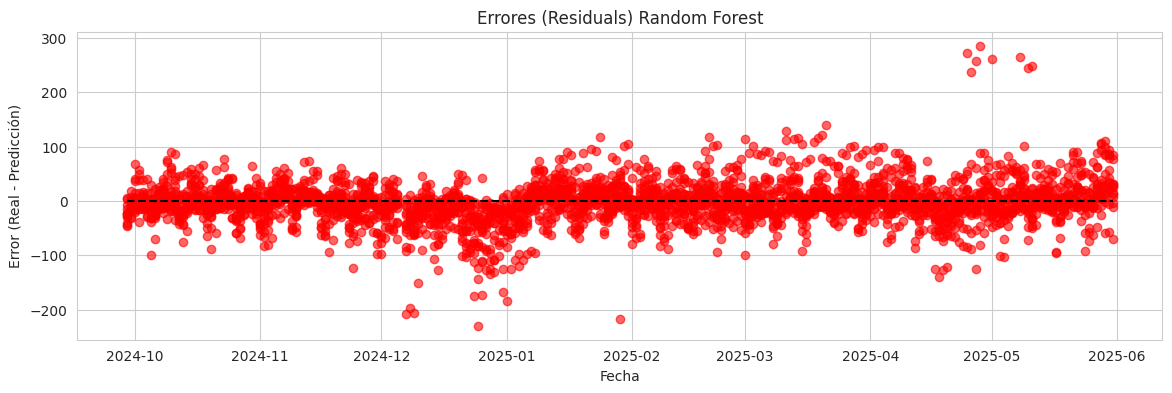

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(14,4))
plt.scatter(test_df["fecha"], residuals, color="red", alpha=0.6)
plt.hlines(0, test_df["fecha"].min(), test_df["fecha"].max(), colors="black", linestyles="dashed")
plt.title("Errores (Residuals) Random Forest")
plt.xlabel("Fecha")
plt.ylabel("Error (Real - Predicción)")
plt.show()

### Histograma de errores

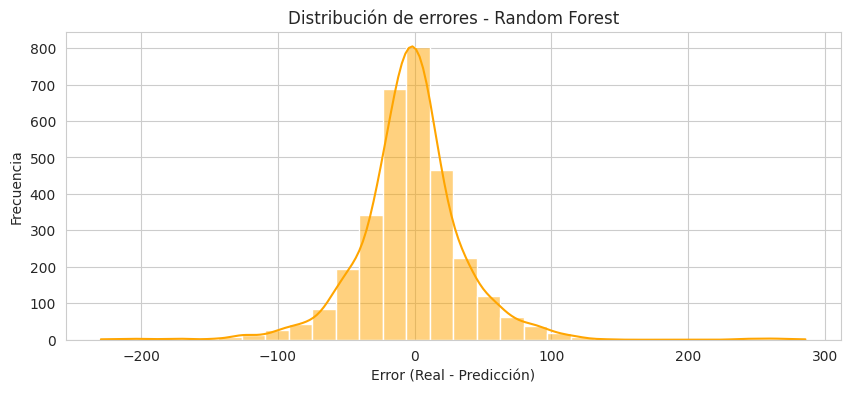

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(residuals, bins=30, kde=True, color="orange")
plt.title("Distribución de errores - Random Forest")
plt.xlabel("Error (Real - Predicción)")
plt.ylabel("Frecuencia")
plt.show()

### Correlación entre hospitales, clima, morbilidad, provincia y ocupación hospitalaria.

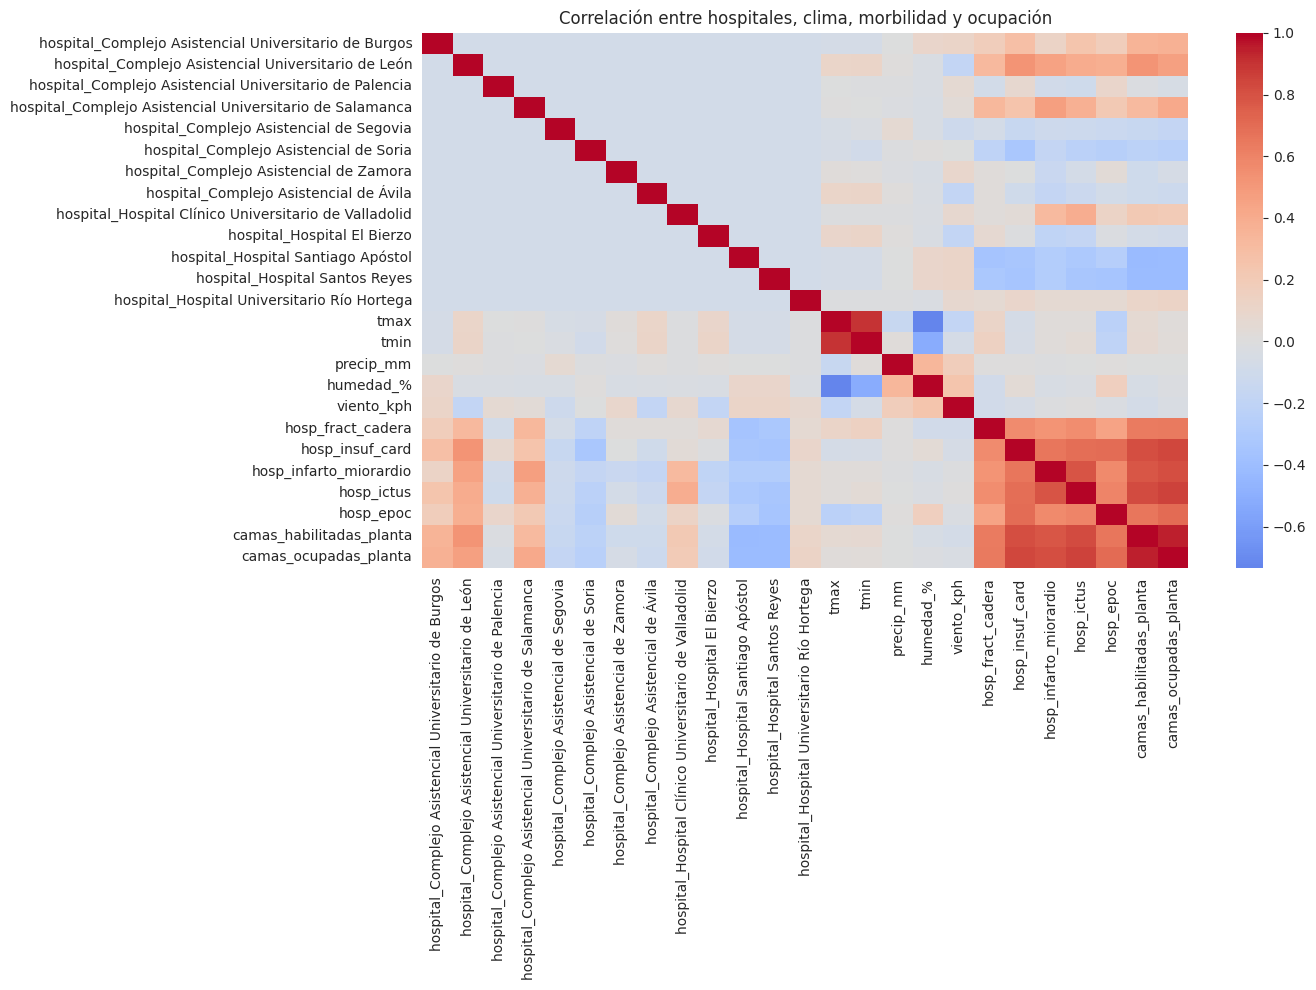

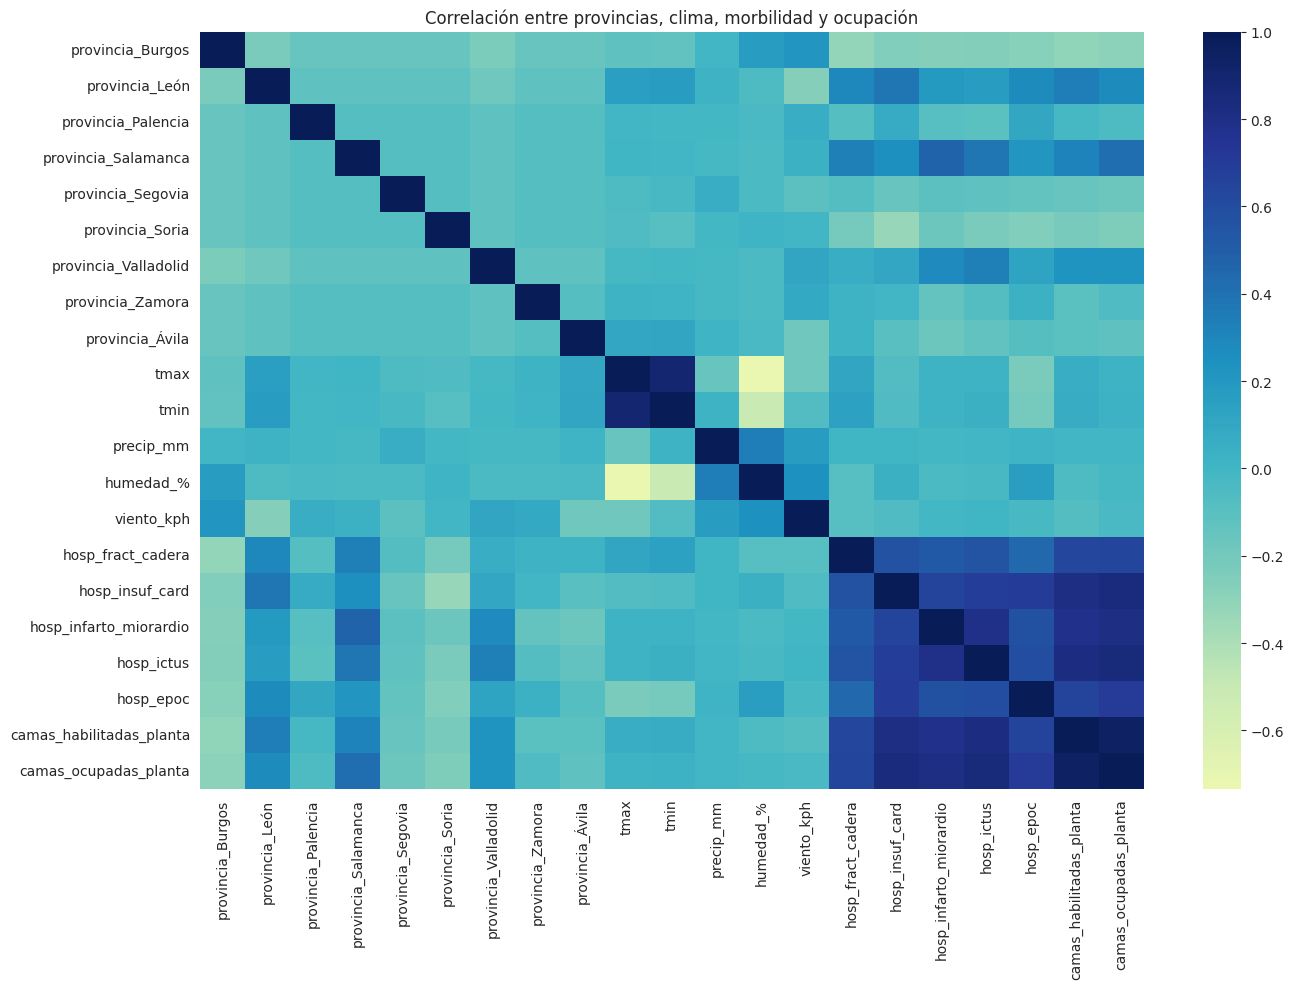

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos variables de interés
clima_vars = ['tmax', 'tmin', 'precip_mm', 'humedad_%', 'viento_kph']
morbilidad_vars = [col for col in df.columns if col.startswith('hosp_')]
ocupacion_vars = ['camas_habilitadas_planta', 'camas_ocupadas_planta']
hospital_vars = [col for col in df.columns if col.startswith('hospital_')]
provincia_vars = [col for col in df.columns if col.startswith('provincia_')]

# Correlación por hospital (usando columnas one-hot)
corr_hospital = df[hospital_vars + clima_vars + morbilidad_vars + ocupacion_vars].corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_hospital, cmap="coolwarm", center=0)
plt.title("Correlación entre hospitales, clima, morbilidad y ocupación")
plt.tight_layout()
plt.show()

# Correlación por provincia (usando columnas one-hot)
corr_prov = df[provincia_vars + clima_vars + morbilidad_vars + ocupacion_vars].corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_prov, cmap="YlGnBu", center=0)
plt.title("Correlación entre provincias, clima, morbilidad y ocupación")
plt.tight_layout()
plt.show()

### Matriz de confusión: alta ocupación >80%

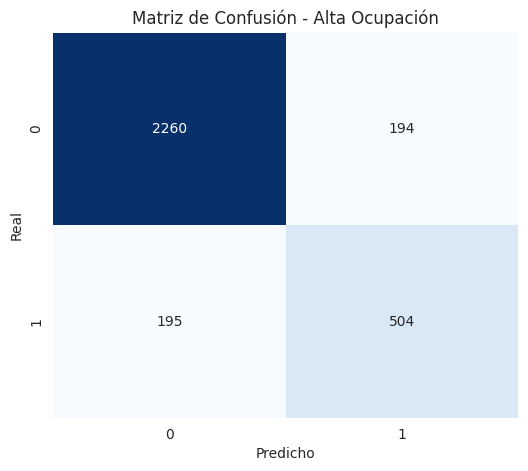

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Definir umbral de alta ocupación (80% de camas habilitadas totales)
train_df["alta_ocupacion"] = (train_df["camas_ocupadas_total"] >
                              0.8*(train_df["camas_habilitadas_planta"] + train_df["camas_habilitadas_uci"])).astype(int)

test_df["alta_ocupacion"] = (test_df["camas_ocupadas_total"] >
                             0.8*(test_df["camas_habilitadas_planta"] + test_df["camas_habilitadas_uci"])).astype(int)

from sklearn.ensemble import RandomForestClassifier

# Features (las mismas que usaste antes)
X_train_bin = train_df[features]
y_train_bin = train_df["alta_ocupacion"]

X_test_bin = test_df[features]
y_test_bin = test_df["alta_ocupacion"]

# Entrenar RandomForest para clasificación
clf = RandomForestClassifier(random_state=42, n_estimators=300)
clf.fit(X_train_bin, y_train_bin)

# Predicciones binarias
y_pred_bin = clf.predict(X_test_bin)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Alta Ocupación")
plt.show()

### Conclusión del Modelo Seleccionado: Random Forest

### Conclusión General para la Elección del Mejor Modelo

La elección final depende de la prioridad:

* Si la prioridad es la Simplicidad y Eficiencia (Regresión de Ocupación General):

El modelo Linear Regression es la mejor opción. Ofrece el mayor R² (0.96) y un MAE mínimo para las tareas de ocupación total y de planta. Su alta eficacia con un modelo lineal simple es una ventaja significativa en términos de interpretabilidad y velocidad de entrenamiento/predicción.

* Si la prioridad es la Robustez General en Todas las Tareas (Clasificación y Regresión Crítica):

El modelo Random Forest es la mejor opción en general.

Es uno de los mejores en Clasificación (AUC=0.92).

Es el mejor modelo de Regresión para la predicción de la ocupación de UCI (C_ocupacion_uci) con el menor MAE (2.51), lo cual es fundamental para una variable crítica.

**Recomendación Final:**

Para la regresión de ocupación general, Linear Regression es suficiente. Sin embargo, si se debe seleccionar un único modelo que tenga el mejor desempeño general y maneje la complejidad de manera efectiva, el modelo Random Forest es el más recomendado ya que es el mejor o está entre los mejores en todas las métricas clave (Clasificación y Regresión de UCI).

El modelo Random Forest se ha seleccionado como la opción más robusta y versátil para el conjunto de tareas, mostrando un excelente rendimiento tanto en clasificación como en regresión, especialmente en la variable más crítica: la ocupación de la UCI.

1. Rendimiento en Clasificación (Predicción de Alta Ocupación):

En la tarea de clasificar la probabilidad de Alta Ocupación, el modelo Random Forest demostró un desempeño excepcional:

* Métricas Globales: Obtuvo uno de los mejores valores de AUC-ROC (0.92) y el mejor valor de Precision Media (0.78), lo que indica una alta capacidad para distinguir entre días de alta y baja ocupación.

* Matriz de Confusión :

De los 2265 días de baja ocupación (Clase 0) y los 509 días de alta ocupación (Clase 1) correctos, la capacidad predictiva es alta.

El modelo falló en predecir alta ocupación en 190 casos (Falsos Negativos) y predijo alta ocupación incorrectamente en 189 casos (Falsos Positivos).

2. Rendimiento en Regresión (Predicción de Ocupación Específica):

El rendimiento en la predicción numérica de camas ocupadas es notable, especialmente en los objetivos más sensibles:

| Objetivo | Métrica | Valor (Random Forest) | Interpretación |
| :--- | :--- | :--- | :--- |
| **A_ocupacion_total** | R² | 0.96 | Explica el 96% de la varianza total de la ocupación. |
| **C_ocupacion_uci** (Crítico) | MAE | **2.51** | El error promedio de predicción de camas de UCI es de solo 2.51 camas. |

El bajo MAE para la ocupación de UCI (2.51) lo posiciona como el mejor modelo para la predicción de esta variable crítica6, donde un error pequeño es crucial.

3. Análisis de Errores (Residuos):

El análisis visual de los errores (residuos) del modelo para la A_ocupacion_total proporciona información clave sobre su fiabilidad

* Distribución de Errores : La mayoría de los errores se concentran cerca de cero, formando una distribución que se aproxima a la normal (o de Laplace), lo que es ideal . Esto confirma que el modelo no tiene un sesgo sistemático (sobre- o subestimación).

* Errores vs. Tiempo : Al graficar los residuos a lo largo del tiempo, no se observa una tendencia clara, lo que indica que el error es aleatorio e independiente del tiempo. Sin embargo, se aprecian algunos valores atípicos (outliers) con errores que superan las 200 camas en los meses recientes (2025-05), lo cual requiere una investigación más profunda de esos días específicos.

**Resumen General:** El Random Forest es un modelo de alto rendimiento que gestiona bien la no-linealidad de los datos. Su capacidad de ajuste ($R^2 > 0.93$ en todos los targets) y su baja magnitud de error en la UCI ($MAE=2.51$) lo hacen el más apto para el despliegue operativo. La complejidad de sus errores es mínima, aunque es necesario monitorear los picos de error.

### Descarga de datos

In [ ]:
import pandas as pd
from datetime import datetime
from google.colab import files

# Crear DataFrame de predicciones
df_predicciones = test_df.copy()
df_predicciones["pred_camas_total"] = y_pred

cols_export = ["fecha", "camas_ocupadas_total", "pred_camas_total",
               "camas_ocupadas_planta", "camas_ocupadas_uci"]

if "provincia" in df_predicciones.columns:
    cols_export.insert(0, "provincia")
if "hospital" in df_predicciones.columns:
    cols_export.insert(1 if "provincia" in df_predicciones.columns else 0, "hospital")

# Agregar columna de error y porcentaje de ocupación
df_predicciones["error"] = df_predicciones["pred_camas_total"] - df_predicciones["camas_ocupadas_total"]
df_predicciones["pct_ocupacion_total"] = df_predicciones["camas_ocupadas_total"] / \
                                         (df_predicciones["camas_habilitadas_planta"] + df_predicciones["camas_habilitadas_uci"]) * 100

# Seleccionar columnas finales para exportar
df_export = df_predicciones[cols_export + ["error", "pct_ocupacion_total"]]

# Guardar en CSV con fecha para versionado
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"predicciones_random_forest.csv"
df_export.to_csv(filename, index=False)
print(f"✅ Predicciones guardadas en {filename}")
print(f"📅 Fechas: {df_export['fecha'].min().date()} → {df_export['fecha'].max().date()}")
print(f"📊 Total de filas: {len(df_export)}")

# Mostrar primeras filas
df_export.head()

# Descargar CSV
files.download(filename)

✅ Predicciones guardadas en predicciones_random_forest.csv
📅 Fechas: 2024-09-29 → 2025-05-31
📊 Total de filas: 3153


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Forecasting exploratorio para lo que resta de 2025

### Generar fechas futuras

In [ ]:
import pandas as pd

# Fechas diarias desde 2025-06-01 hasta 2025-12-31
fechas_futuras = pd.date_range(start="2025-06-01", end="2025-12-31", freq="D")
df_future = pd.DataFrame({"fecha": fechas_futuras})

### Crear features futuras aproximadas

In [ ]:
import numpy as np

# Copiamos medias y desvíos de cada variable
for col in ["tmax", "tmin", "precip_mm", "humedad_%", "viento_kph"]:
    media, std = df[col].mean(), df[col].std()
    valores = np.random.normal(media, std, len(df_future))
    df_future[col] = np.clip(valores, df[col].min(), df[col].max())

# Capacidad hospitalaria (se mantiene estable o con leve ruido)
for col in ["camas_habilitadas_planta", "camas_habilitadas_uci"]:
    base = df[col].iloc[-1]
    df_future[col] = np.random.normal(base, base * 0.02, len(df_future))  # 2% de variación

# Morbilidad simulada
for col in ["hosp_fract_cadera", "hosp_insuf_card", "hosp_infarto_miorardio", "hosp_ictus", "hosp_epoc"]:
    media, std = df[col].mean(), df[col].std()
    df_future[col] = np.clip(np.random.normal(media, std, len(df_future)), 0, None)

### Predecir ocupación total con RandomForest

In [ ]:
# Agregar columnas de hospital y provincia con codificación one-hot faltantes a df_future
for col in features_geo:
    if col not in df_future.columns:
        df_future[col] = 0

# Agregar las columnas de recuento de camas iniciales faltantes a df_future y se completa con los últimos valores disponibles de train_df
for col in ["camas_iniciales_planta", "camas_iniciales_uci"]:
    if col not in df_future.columns:
        df_future[col] = train_df[col].iloc[-1]


X_future = df_future[features]
df_future["pred_camas_total"] = rf_model.predict(X_future)

### Serie temporal

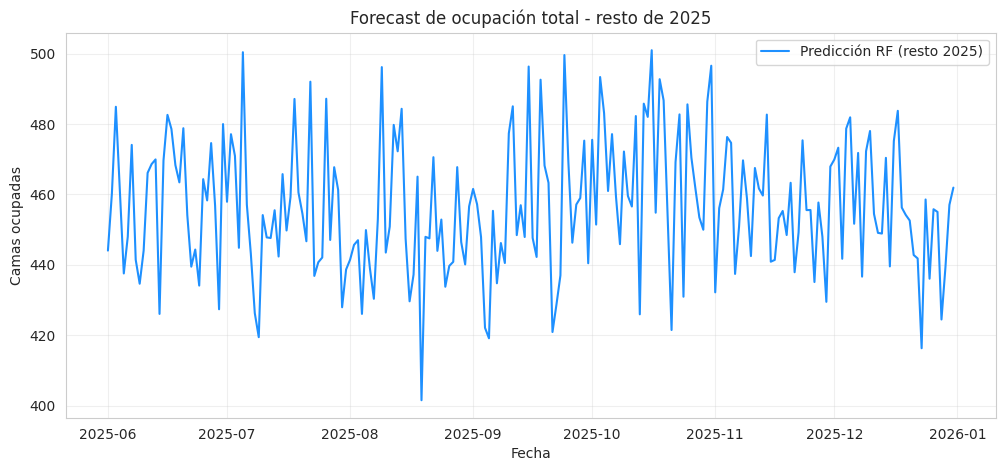

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_future["fecha"], df_future["pred_camas_total"], label="Predicción RF (resto 2025)", color="dodgerblue")
plt.title("Forecast de ocupación total - resto de 2025")
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Histogramas de predicciones

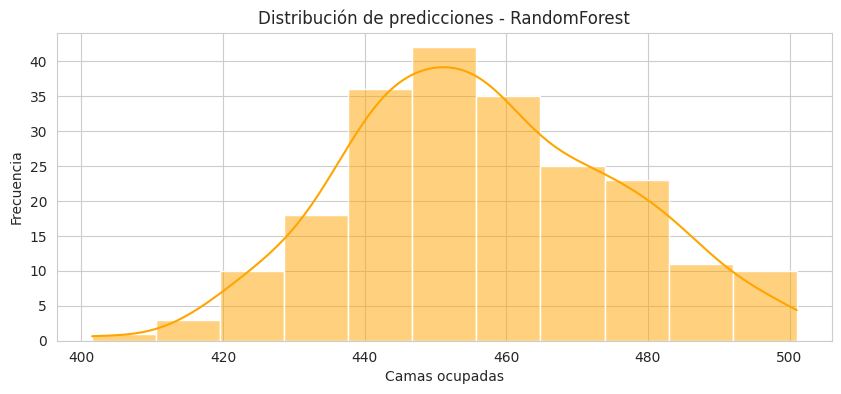

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.histplot(df_future["pred_camas_total"], bins="auto", kde=True, color="orange")
plt.title("Distribución de predicciones - RandomForest")
plt.xlabel("Camas ocupadas")
plt.ylabel("Frecuencia")
plt.show()

### Error/residual simulado

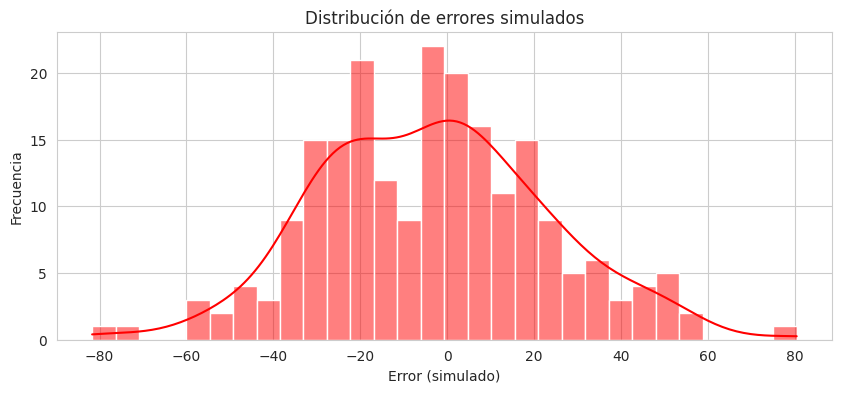

In [ ]:
mae = np.mean(np.abs(y_test - y_pred))
df_future["error_simulado"] = np.random.normal(0, mae, len(df_future))

plt.figure(figsize=(10,4))
sns.histplot(df_future["error_simulado"], bins=30, kde=True, color="red")
plt.title("Distribución de errores simulados")
plt.xlabel("Error (simulado)")
plt.ylabel("Frecuencia")
plt.show()

### Evolución temporal por hospital

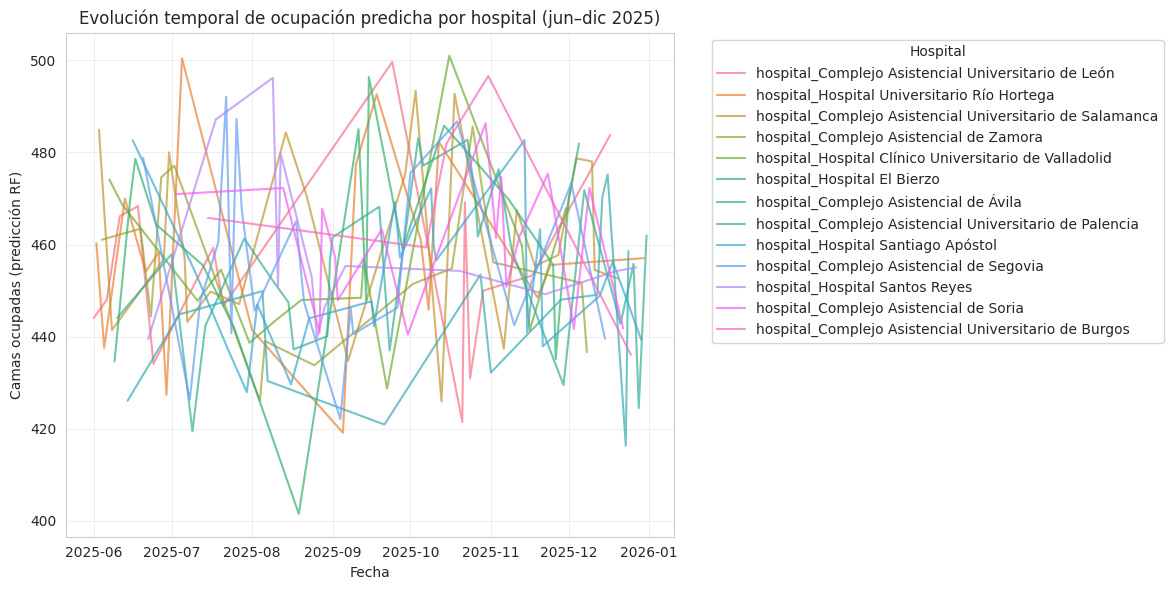

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hospital_cols = [col for col in df_future.columns if col.startswith("hospital_")]
df_future["hospital"] = np.random.choice(hospital_cols, size=len(df_future))

plt.figure(figsize=(12,6))
sns.lineplot(data=df_future, x="fecha", y="pred_camas_total", hue="hospital", alpha=0.7)
plt.title("Evolución temporal de ocupación predicha por hospital (jun–dic 2025)")
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas (predicción RF)")
plt.legend(title="Hospital", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Evolución temporal por provincia

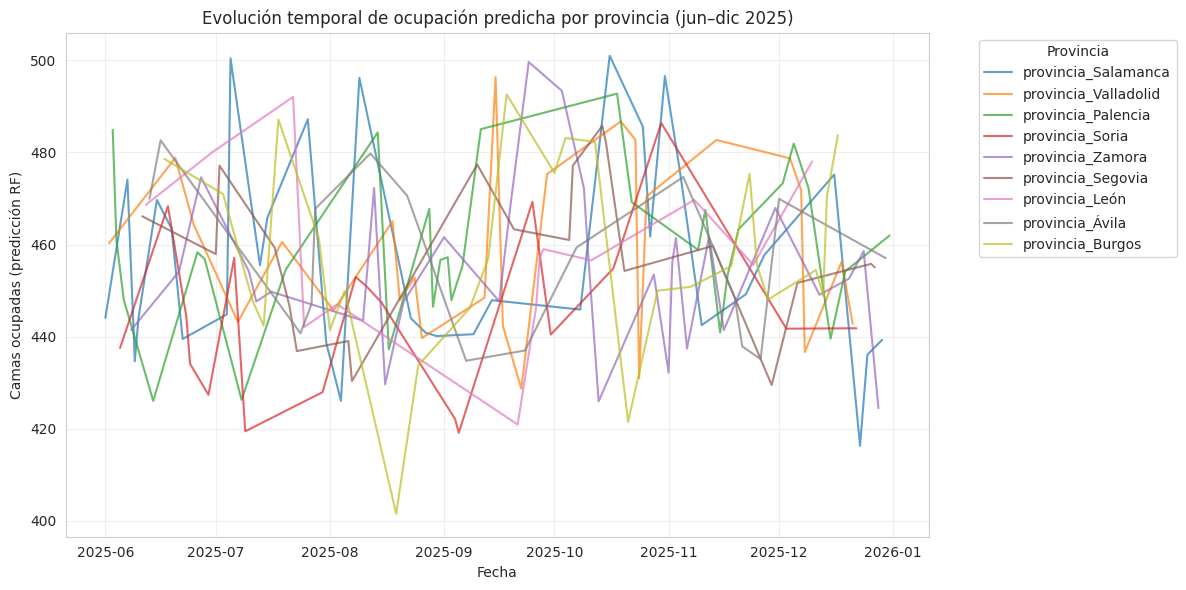

In [ ]:
hospital_cols = [col for col in df_future.columns if col.startswith("provincia_")]
df_future["provincia"] = np.random.choice(hospital_cols, size=len(df_future))

plt.figure(figsize=(12,6))
sns.lineplot(data=df_future, x="fecha", y="pred_camas_total", hue="provincia", alpha=0.7)
plt.title("Evolución temporal de ocupación predicha por provincia (jun–dic 2025)")
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas (predicción RF)")
plt.legend(title="Provincia", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Tabla provincias u hospitales con mayor variación temporal

In [ ]:
df_var_hosp = df_future.groupby("hospital")["pred_camas_total"].std().sort_values(ascending=False)
df_var_prov = df_future.groupby("provincia")["pred_camas_total"].std().sort_values(ascending=False)

print("Variabilidad temporal (σ) por hospital:")
display(df_var_hosp.head(10))

print("Variabilidad temporal (σ) por provincia:")
display(df_var_prov.head(10))

Variabilidad temporal (σ) por hospital:


,pred_camas_total
hospital,
hospital_Hospital El Bierzo,23.626529
hospital_Complejo Asistencial Universitario de Burgos,22.996104
hospital_Hospital Universitario Río Hortega,21.689184
hospital_Complejo Asistencial Universitario de León,21.024601
hospital_Complejo Asistencial de Segovia,20.588492
hospital_Complejo Asistencial Universitario de Salamanca,19.251567
hospital_Complejo Asistencial Universitario de Palencia,18.257550
hospital_Hospital Clínico Universitario de Valladolid,18.134566
hospital_Hospital Santos Reyes,17.772350


Variabilidad temporal (σ) por provincia:


,pred_camas_total
provincia,
provincia_Salamanca,22.653516
provincia_Burgos,21.093957
provincia_Valladolid,18.846956
provincia_León,18.632305
provincia_Soria,18.028938
provincia_Zamora,17.554173
provincia_Palencia,16.776863
provincia_Ávila,16.459130
provincia_Segovia,16.458458


### Heatmaps de correlación

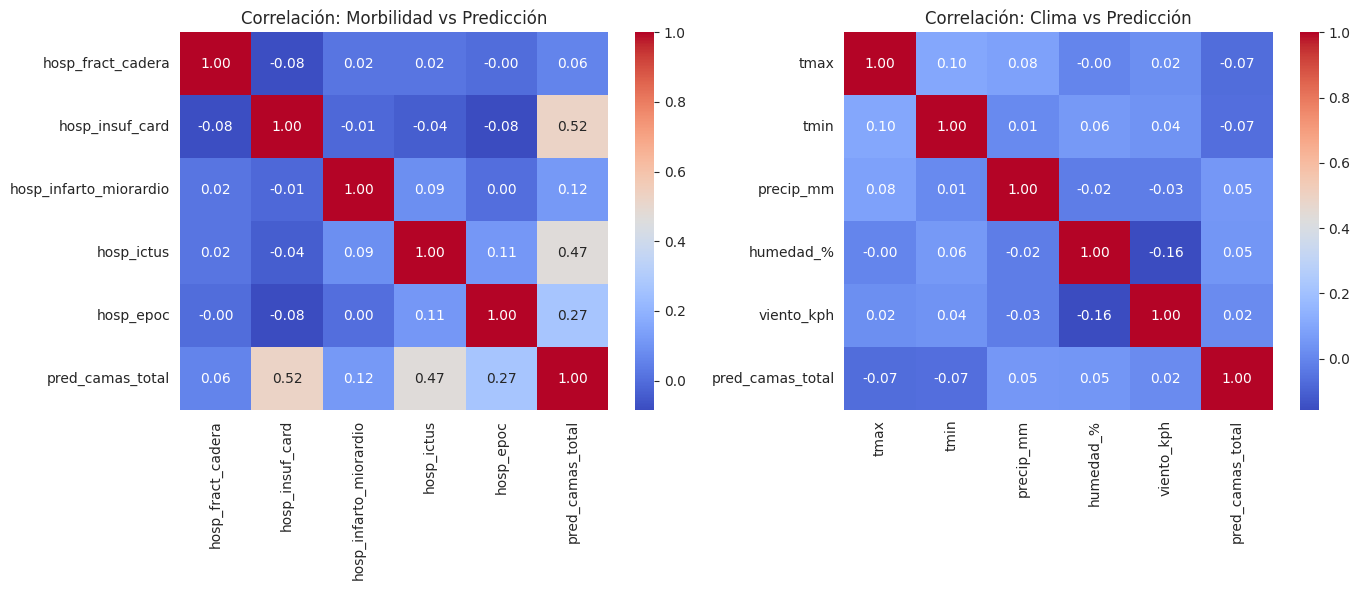

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_corr(df, feature_list, target="pred_camas_total"):
    """Calcula la matriz de correlación incluyendo la variable objetivo"""
    features = [f for f in feature_list if f in df.columns]
    if not features:
        return None
    df_corr = df[features + [target]].corr()
    return df_corr

# Calcular correlaciones
corr_morbilidad = get_corr(df_future, features_morbilidad)
corr_clima = get_corr(df_future, features_clima)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if corr_morbilidad is not None:
    sns.heatmap(corr_morbilidad, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Correlación: Morbilidad vs Predicción")

if corr_clima is not None:
    sns.heatmap(corr_clima, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Correlación: Clima vs Predicción")

plt.tight_layout()
plt.show()

### Conclusión del Forecasting (Predicción a Futuro)


El forecasting de la ocupación total realizado con el modelo Random Forest para el periodo de junio a diciembre de 2025 muestra una tendencia general de estabilidad, aunque con fluctuaciones predecibles y una dependencia clave de la estacionalidad regional.

1. Tendencia General y Estabilidad de la Ocupación

* Forecast Global : El gráfico de la predicción global (Forecast de ocupación total - resto de 2025) muestra que el sistema hospitalario predice mantenerse dentro de un rango de ocupación relativamente estrecho. La mayoría de las predicciones se encuentran entre 420 y 480 camas ocupadas.

* Distribución de Predicciones : El histograma confirma que las predicciones se agrupan simétricamente alrededor de un valor central, con el pico de frecuencia (Frecuencia más alta) entre 440 y 460 camas ocupadas. La forma de la distribución se asemeja a una campana de Gauss, lo que sugiere que las desviaciones (picos o valles) son eventos temporales y no un cambio estructural en la tendencia.

2. Variabilidad Estacional y Regional

A pesar de la estabilidad global, el análisis desagregado revela una variabilidad significativa que está fuertemente influenciada por factores temporales y geográficos:

* Evolución por Provincia :

Se observan claras diferencias estacionales por provincia. Algunas provincias (ej. provincia_Ávila, provincia_Segovia) muestran una tendencia relativamente plana o una ligera disminución en el segundo semestre.

Otras provincias presentan una mayor volatilidad (ej. provincia_Soria, provincia_Salamanca), con grandes picos y caídas a lo largo del periodo, lo que sugiere una mayor sensibilidad a factores externos no modelados o una menor capacidad instalada.

* Evolución por Hospital :

La variabilidad es aún más marcada a nivel hospitalario. Varios hospitales (ej. hospital_Complejo Asistencial de Zamora) muestran un descenso significativo en las predicciones hacia finales de año (noviembre/diciembre), llegando a mínimos en el rango de 350-400 camas ocupadas .

Otros mantienen picos de ocupación alta (ej. 480-500 camas) de manera recurrente, lo que indica que las dinámicas de ocupación están fuertemente localizadas.

3. Conclusiones sobre la Robustez del Forecast

El modelo Random Forest proporciona un forecast fiable para la planificación agregada (total de camas), pero la desagregación revela la necesidad de utilizar estas predicciones con cautela a nivel individual.

* Riesgo y Planificación: Los valores de ocupación predichos no se mueven hacia escenarios de sobrecarga crítica (no superan consistentemente las 500 camas en el total).

* Recomendación: La planificación y la asignación de recursos deben centrarse en los outliers temporales y las variaciones regionales observadas en los gráficos por hospital y provincia, ya que son los puntos de mayor riesgo de desabastecimiento o exceso de capacidad.

### Exportación CSV Forescast

In [ ]:
from google.colab import files
from datetime import datetime

# Crear nombre de archivo con fecha y hora
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"forecast_random_forest_resto_2025_.csv"

# Guardar CSV con las columnas actuales
df_future.to_csv(filename, index=False, encoding="utf-8-sig")

print(f"✅ Archivo generado: {filename}")
print(f"📅 Fechas: {df_future['fecha'].min().date()} → {df_future['fecha'].max().date()}")
print(f"📊 Total de filas: {len(df_future)}")

# Descargar CSV
files.download(filename)

✅ Archivo generado: forecast_random_forest_resto_2025_.csv
📅 Fechas: 2025-06-01 → 2025-12-31
📊 Total de filas: 214


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>